In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from shapely.geometry import box,Polygon
# Example polygon 
xy = [[130.21001, 27.200001], [129.52, 27.34], [129.45, 27.1], [130.13, 26.950001]]
polygon_shape = Polygon(xy)
# Example grid cell
gridcell_shape = box(129.5, -27.0, 129.75, 27.25)
# The intersection
polygon_shape.intersection(gridcell_shape).area

0.047150670955882656

In [3]:
%load_ext autoreload
%autoreload 2
from analysis_toolbox import *

In [4]:
import ast
from qualityBaseline import * 
from pycocotools.coco import COCO
import matplotlib.image as mpimg
save_db_as_csv(connect=False)
img_info,object_tbl,bb_info,hit_info = load_info()

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [5]:
all_x_locs = bb_info["x_locs"]
all_y_locs = bb_info["y_locs"]

In [6]:
dataDir='../../coco/'
dataType='train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=23.77s)
creating index...
index created!


In [7]:
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")

In [8]:
def process_raw_locs(segmentation,COCO=False):
    '''
    Given a raw string of x and y coordinates, process it
    return a list of x_locs and y_locs
    '''
    x_locs=[]
    y_locs=[]
    if COCO:
        #COCO
#         print "Process COCO"
        poly = np.array(segmentation).reshape((len(segmentation)/2, 2))
        x_locs = list(poly[:,0])
        y_locs = list(poly[:,1])
    else: 
        bbx_path,bby_path = segmentation
        x_locs = [x for x in ast.literal_eval(bbx_path) if x is not None]
        y_locs = [y for y in ast.literal_eval(bby_path) if y is not None]


    # Append the starting point again in the end to close the BB
    x_locs.append(x_locs[0])
    y_locs.append(y_locs[0])
    return x_locs,y_locs

#Installing shapely
``
pip install shapely==1.6b2
export DYLD_FALLBACK_LIBRARY_PATH=/usr/local/lib:/lib:/usr/lib
``

In [16]:
# Example polygon 
xy = [[130.21001, 27.200001], [129.52, 27.34], [129.45, 27.1], [130.13, 26.950001]]
polygon_shape = Polygon(xy)
# Example grid cell
gridcell_shape = box(129.5, -27.0, 129.75, 27.25)
# The intersection
polygon_shape.intersection(gridcell_shape).area

0.047150670955882656

In [34]:
obj_x_locs=[[1,3,3,1],[2,5,5,2]]
obj_y_locs=[[3,3,1,1],[2,2,0,0]]
polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0]))
polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1]))
polygon1.intersection(polygon2).area

1.0

In [109]:
from shapely.geometry import box,Polygon
def intersection(obj_x_locs,obj_y_locs,debug=False):
    # Compute intersecting area
    polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
    polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)
    if debug : plt.imshow(polygon1.intersection(polygon2),interpolation="None")
    return polygon1.intersection(polygon2).area

In [110]:
def union(obj_x_locs,obj_y_locs,debug=False):
    # Compute union area of two given polygon 
    polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
    polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)
    if debug : plt.imshow(polygon1.union(polygon2),interpolation="None")
    return polygon1.union(polygon2).area

In [111]:
def majority_vote(obj_x_locs,obj_y_locs): 
    '''
    Jaccard Simmilarity or Overlap Method
    used for PASCAL VOC challenge
    ''' 
    return intersection(obj_x_locs,obj_y_locs)/union(obj_x_locs,obj_y_locs)

In [112]:
def precision(obj_x_locs,obj_y_locs):
    worker_bb = Polygon(zip(obj_x_locs[0],obj_y_locs[0]))
    worker_bb_area  = worker_bb.area
#     print "Intersection: ", intersection(obj_x_locs,obj_y_locs)
#     print "Worker BB area: ",worker_bb_area
    return intersection(obj_x_locs,obj_y_locs)/float(worker_bb_area)

In [113]:
def recall(obj_x_locs,obj_y_locs):
    truth_bb = Polygon(zip(obj_x_locs[1],obj_y_locs[1]))
    truth_bb_area  = truth_bb.area
    return intersection(obj_x_locs,obj_y_locs)/float(truth_bb_area)

In [114]:
# 2 simple overlapping rectangle test example 
obj_x_locs=[[1,3,3,1],[2,5,5,2]]
obj_y_locs=[[3,3,1,1],[2,2,0,0]]
print "Check ``union``: ", union(obj_x_locs,obj_y_locs) == 9
print "Check ``intersection``: ", intersection(obj_x_locs,obj_y_locs) == 1.
print "Check ``majority_vote``: ", majority_vote(obj_x_locs,obj_y_locs) == 1./9
print "Check ``precision``: ", precision(obj_x_locs,obj_y_locs) == 1./4
print "Check ``recall``: ", recall(obj_x_locs,obj_y_locs) == 1./6

Check ``union``:  True
Check ``intersection``:  True
Check ``majority_vote``:  True
Check ``precision``:  True
Check ``recall``:  True


### Visualize all bounding boxes drawn by me , see which one is bad and redraw BBG 

In [73]:
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")
worker_info = pd.read_csv("../../data/worker.csv",skipfooter=1)
my_BBG  = pd.read_csv("my_ground_truth.csv")

### Computing measures against my BBG and COCO

In [105]:
polygon1 = Polygon(zip(obj_x_locs[0],obj_y_locs[0])).buffer(0)
polygon2 = Polygon(zip(obj_x_locs[1],obj_y_locs[1])).buffer(0)

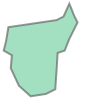

In [107]:
polygon1

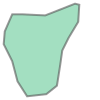

In [108]:
polygon2

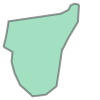

In [106]:
polygon1.intersection(polygon2)

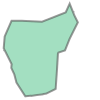

In [147]:
polygon1.union(polygon2)

In [116]:
for i in np.arange(len(img_info)):
    img_name = img_info["filename"][i]
    if 'COCO' in img_name:
        img_id = int(img_name.split('_')[-1])
        filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]
        annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = coco.loadAnns(annIds)
        #for oid,bbx_path,bby_path in zip(bb_info["object_id"],bb_info["x_locs"],bb_info["y_locs"]):
        for bb in bb_info.iterrows():
            oid = bb[1]["object_id"]
            bbx_path= bb[1]["x_locs"]
            bby_path= bb[1]["y_locs"]
            if int(object_tbl[object_tbl.object_id==oid].image_id) ==i+1:
                worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
                ground_truth_match = ground_truth[ground_truth.id==str(oid)]
                COCO_id = int(ground_truth_match["COCO_annIds"])
                
                #COCO-Annotations
                for ann in anns:
                    if COCO_id==-1:
                        #No BB for this object collected by MSCOCO
                        pass
                    elif ann['id'] == COCO_id: 
#                         print COCO_id
                        for annBB in ann["segmentation"]:
                            coco_x_locs,coco_y_locs = process_raw_locs(annBB,COCO=True)
                            obj_x_locs = [worker_x_locs,coco_x_locs]
                            obj_y_locs = [worker_y_locs,coco_y_locs]
                            bb_info = bb_info.set_value(bb[0],"COCO Majority Vote",majority_vote(obj_x_locs,obj_y_locs))
                            #bb_info = bb_info.set_value(bb[0],"Munkres Euclidean",DistAllWorkers(obj_x_locs,obj_y_locs))
                            bb_info = bb_info.set_value(bb[0],"COCO Precision",precision(obj_x_locs,obj_y_locs))
                            bb_info = bb_info.set_value(bb[0],"COCO Recall",recall(obj_x_locs,obj_y_locs))                
                my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
                my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
                obj_x_locs = [worker_x_locs,my_x_locs]
                obj_y_locs = [worker_y_locs,my_y_locs]
                bb_info = bb_info.set_value(bb[0],"My Majority Vote",majority_vote(obj_x_locs,obj_y_locs))   
                bb_info = bb_info.set_value(bb[0],"My Precision",precision(obj_x_locs,obj_y_locs))
                bb_info = bb_info.set_value(bb[0],"My Recall",recall(obj_x_locs,obj_y_locs))
# replace all NAN values with -1, these are entries for which we don't have COCO ground truth
bb_info = bb_info.fillna(-1)

In [149]:
bb_info.to_csv("computed_my_COCO_BBvals.csv")

### Use Kolmogorov-Smirnov test to see how well the distributions fit a Gaussian 


In [124]:
from scipy import stats

(0, 1.05)

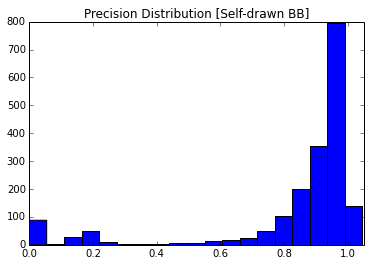

In [159]:
my_precision = np.array(bb_info["My Precision"][bb_info["My Precision"]!=-1])
plt.figure()
plt.title("Precision Distribution [Self-drawn BB]")
plt.hist(my_precision,bins=1000)
plt.xlim(0,1.05)

(0, 1.05)

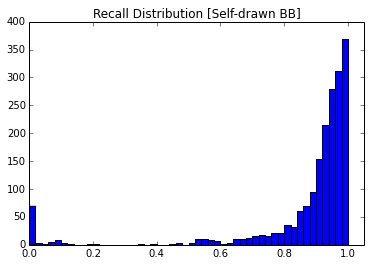

In [160]:
my_recall = np.array(bb_info["My Recall"][bb_info["My Recall"]!=-1])
plt.figure()
plt.title("Recall Distribution [Self-drawn BB]")
plt.hist(my_recall,bins=50)
plt.xlim(0,1.05)

In [161]:
print  stats.kstest(my_precision, 'norm')
print stats.kstest(my_recall, 'norm')

(0.63390175005377802, 0.0)
(0.66631878187717508, 0.0)


In [162]:
print stats.kstest(my_precision, 'expon')
print stats.kstest(my_recall, 'expon')

(0.38691067457919365, 0.0)
(0.41326489697122637, 0.0)


(0, 1.1)

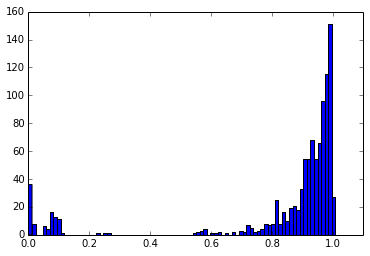

In [172]:
coco_precision = np.array(bb_info["COCO Precision"][bb_info["COCO Precision"]!=-1])
coco_recall = np.array(bb_info["COCO Recall"][bb_info["COCO Recall"]!=-1])
plt.hist(coco_precision,bins=200)
plt.xlim(0,1.1)

# MLE Fitting 

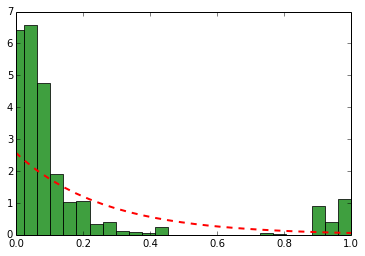

In [284]:
# Based on MLE estimate for fitting
params = stats.expon.fit(1-coco_precision)
n, bins, patches = plt.hist(1-coco_precision, 60, normed=1, facecolor='green', alpha=0.75)
plt.xlim(0,1)
y = stats.expon.pdf( bins, *params)
l = plt.plot(bins, y, 'r--', linewidth=2)

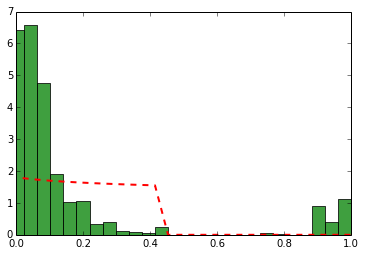

In [291]:
# Based on MLE estimate for fitting
params = stats.powerlaw.fit(1-coco_precision)
n, bins, patches = plt.hist(1-coco_precision, 60, normed=1, facecolor='green', alpha=0.75)
plt.xlim(0,1)
y = stats.powerlaw.pdf( bins, *params)
l = plt.plot(bins, y, 'r--', linewidth=2)

In [294]:
# dir(stats)

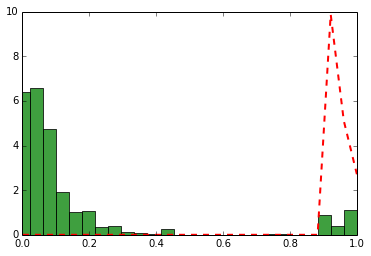

In [286]:
# Based on MLE estimate for fitting
params = stats.pareto.fit(1-coco_precision)
n, bins, patches = plt.hist(1-coco_precision, 60, normed=1, facecolor='green', alpha=0.75)
plt.xlim(0,1)
y = stats.pareto.pdf(bins, *params)
l = plt.plot(bins, y, 'r--', linewidth=2)

#### It's easier to fit f in 1-f(x) form for this dataset , not really 

(0, 1.1)

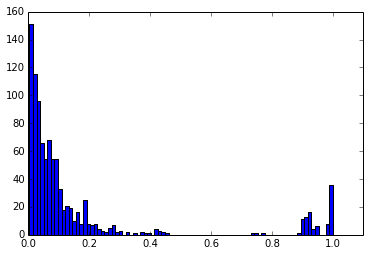

In [174]:
coco_precision = np.array(bb_info["COCO Precision"][bb_info["COCO Precision"]!=-1])
coco_recall = np.array(bb_info["COCO Recall"][bb_info["COCO Recall"]!=-1])
plt.hist(1-coco_precision,bins=200)
plt.xlim(0,1.1)

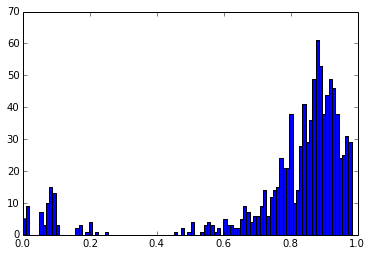

In [302]:
my_jaccard = np.array(bb_info["COCO Majority Vote"][bb_info["COCO Majority Vote"]!=0])
coco_jaccard = np.array(bb_info["My Majority Vote"][bb_info["My Majority Vote"]!=-1])
a = plt.hist(my_jaccard,bins=100)
# plt.xlim(0,1.1)

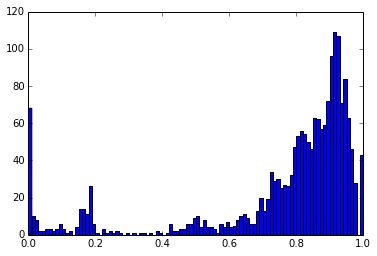

In [301]:
b = plt.hist(coco_jaccard,bins=100)

#### The null hypothesis is that the sample is not drawn from the reference distribution, so if p>0.05 then reject null hypothesis, they are drawn from that distribution. [see stats_helper.py]

In [232]:
stats.kstest(stats.norm.rvs(size=100), 'norm')

(0.055054505094351391, 0.92226833701059863)

In [236]:
def pcheck(p,null_hyp):
    '''
    if p>0.05 then reject null hypothesis
    '''
    if p>0.05:
        return  null_hyp
    else:
        return "NOT "+null_hyp

In [237]:
def one_way_kolmogorov_smirnov(data,name,distr_name):
	'''
	See if data come from the reference distribution
	'''
	result = stats.kstest(data,distr_name)
	print "{0} : D = {1} ; p ={2} ---> {3}".format(name,np.around(result[0],2),np.around(result[1],2),pcheck(result[1],"from {} distribution".format(distr_name)))

In [244]:
for test_distr in ['expon','norm']:
    print '------------------------{}------------------------'.format(test_distr)
    one_way_kolmogorov_smirnov(coco_precision,'COCO Precision',test_distr)
    one_way_kolmogorov_smirnov(coco_recall,'COCO Recall',test_distr)
    one_way_kolmogorov_smirnov(my_precision,'Self Precision',test_distr)
    one_way_kolmogorov_smirnov(my_recall,'Self Recall',test_distr)

------------------------expon------------------------
COCO Precision : D = 0.4 ; p =0.0 ---> NOT from expon distribution
COCO Recall : D = 0.43 ; p =0.0 ---> NOT from expon distribution
Self Precision : D = 0.39 ; p =0.0 ---> NOT from expon distribution
Self Recall : D = 0.41 ; p =0.0 ---> NOT from expon distribution
------------------------norm------------------------
COCO Precision : D = 0.64 ; p =0.0 ---> NOT from norm distribution
COCO Recall : D = 0.67 ; p =0.0 ---> NOT from norm distribution
Self Precision : D = 0.63 ; p =0.0 ---> NOT from norm distribution
Self Recall : D = 0.67 ; p =0.0 ---> NOT from norm distribution


In [189]:
print stats.kstest(1-coco_precision, 'pareto',args=[2])
print stats.kstest(1-coco_recall, 'pareto',args=[2])

(1.0, 0.0)
(1.0, 0.0)


In [178]:
print stats.kstest(1-coco_precision, 'powerlaw',args=[2])
print stats.kstest(1-coco_recall, 'powerlaw',args=[2])

(0.8090654868653665, 0.0)
(0.83643491334040732, 0.0)


(0, 5)

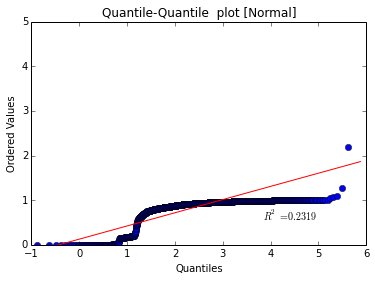

In [143]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(my_precision, dist=stats.norm, sparams=(2.5,), plot=ax)
ax.set_title("Quantile-Quantile  plot [Normal]")
ax.set_ylim(0,5)

In [303]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# res = stats.probplot(1-my_precision, dist=stats.expon, sparams=(2.5,), plot=ax)
# ax.set_title("Quantile-Quantile  plot [Exponential]")
# ax.set_ylim(0,5)

In [295]:
def basic_stats(data1,data2,mode="double"):
	print "Precision: mu = {0}; std = {1}".format(np.around(mean(data1),3),np.around(std(data1),3))
	if mode=="double": print "Recall: mu = {0}; std = {1}".format(np.around(mean(data2),3),np.around(std(data2),3))

In [296]:
basic_stats(my_precision,my_recall)

Precision: mu = 0.866; std = 1.272
Recall: mu = 0.871; std = 0.214


In [297]:
basic_stats(coco_precision,coco_recall)

Precision: mu = 0.843; std = 0.275
Recall: mu = 0.868; std = 0.204


These distributions are very far from a normal or even an exponential distribution, even when you filter out the outliers 

Other quantities: boundary complexity, comparison with color mixture and hues from CV 

In [312]:
bb_info.hist?

array([[<matplotlib.axes.AxesSubplot object at 0x11c419910>,
        <matplotlib.axes.AxesSubplot object at 0x11874df50>]], dtype=object)

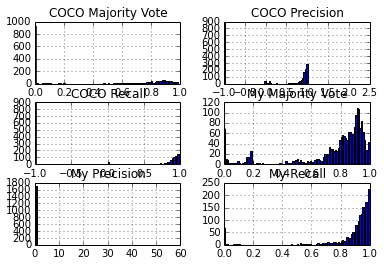

In [314]:
bb_info.hist(column=['COCO Precision','COCO Recall','COCO Majority Vote','My Precision','My Recall','My Majority Vote'],bins=100)

In [361]:
def basic_stat(data1,name):
	print "{0}: mu = {1}; std = {2}".format(name,np.around(mean(data1),3),np.around(std(data1),3))
	return [name,np.around(mean(data1),3),np.around(std(data1),3)]

Precision [COCO]: mu = 0.869; std = 0.227
Recall [COCO]: mu = 0.897; std = 0.132
Jaccard [COCO]: mu = 0.789; std = 0.227
Precision [Self]: mu = 0.864; std = 0.206
Recall [Self]: mu = 0.901; std = 0.145
Jaccard [Self]: mu = 0.785; std = 0.219


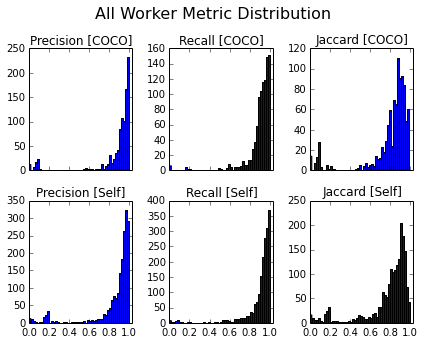

In [399]:
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']

NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW

fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
fig.suptitle("All Worker Metric Distribution ".format(FILTER_CRITERION),fontsize=16,y=1.05)

axs = axs.ravel()
table_data = []
for i,metric in zip(range(len(metrics_lst)),metrics_lst):
    metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
    table_data.append(basic_stat(metric_value,metric))
    ax = axs[i]
    ax.set_title(metric)
    ax.hist(metric_value,bins=50)
    ax.set_xlim(0,1.03)
fig.tight_layout()
fig.savefig('metric_histogram.pdf')

In [400]:
from tabulate import tabulate

In [401]:
print tabulate(table_data,headers=["All","Mean","SD"],tablefmt='latex')

\begin{tabular}{lrr}
\hline
 All              &   Mean &    SD \\
\hline
 Precision [COCO] &  0.869 & 0.227 \\
 Recall [COCO]    &  0.897 & 0.132 \\
 Jaccard [COCO]   &  0.789 & 0.227 \\
 Precision [Self] &  0.864 & 0.206 \\
 Recall [Self]    &  0.901 & 0.145 \\
 Jaccard [Self]   &  0.785 & 0.219 \\
\hline
\end{tabular}


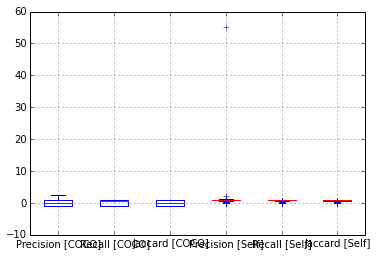

In [356]:
a = bb_info.boxplot(column=['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]'])

# Good Worker's Measures 

Precision [COCO]: mu = 0.931; std = 0.068
COCO Precision : D = 0.5 ; p =0.0 ---> NOT from expon distribution
COCO Precision : D = 0.75 ; p =0.0 ---> NOT from norm distribution
COCO Precision : D = 0.69 ; p =0.0 ---> NOT from cauchy distribution
Recall [COCO]: mu = 0.917; std = 0.07
COCO Precision : D = 0.49 ; p =0.0 ---> NOT from expon distribution
COCO Precision : D = 0.74 ; p =0.0 ---> NOT from norm distribution
COCO Precision : D = 0.68 ; p =0.0 ---> NOT from cauchy distribution
Jaccard [COCO]: mu = 0.858; std = 0.082
COCO Precision : D = 0.46 ; p =0.0 ---> NOT from expon distribution
COCO Precision : D = 0.73 ; p =0.0 ---> NOT from norm distribution
COCO Precision : D = 0.67 ; p =0.0 ---> NOT from cauchy distribution
Precision [Self]: mu = 0.918; std = 0.076
COCO Precision : D = 0.49 ; p =0.0 ---> NOT from expon distribution
COCO Precision : D = 0.74 ; p =0.0 ---> NOT from norm distribution
COCO Precision : D = 0.67 ; p =0.0 ---> NOT from cauchy distribution
Recall [Self]: mu = 0.9

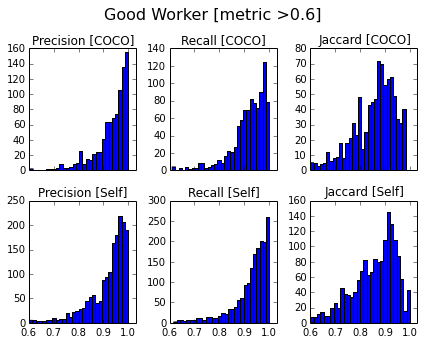

In [419]:
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
FILTER_CRITERION = 0.6
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW

fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
fig.suptitle("Good Worker [metric >{}]".format(FILTER_CRITERION),fontsize=16,y=1.05)
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

table_data = []
for i,metric in zip(range(len(metrics_lst)),metrics_lst):
    metric_value = np.array(bb_info[metric][bb_info[metric]>FILTER_CRITERION][bb_info[metric]<=1]) 
    table_data.append(basic_stat(metric_value,metric))
    ax = axs[i]
    ax.set_title(metric)
    ax.hist(metric_value,bins=30)
    ax.set_xlim(FILTER_CRITERION,1.03)
    #Testing against various distributions 
    for test_distr in ['expon','norm','cauchy']:
        one_way_kolmogorov_smirnov(metric_value,'COCO Precision',test_distr)
fig.tight_layout()
fig.savefig('good_worker_metric_histogram.pdf')

In [397]:
print tabulate(table_data,headers=["Mean","SD"],tablefmt='latex')

\begin{tabular}{lrr}
\hline
                  &   Mean &    SD \\
\hline
 Precision [COCO] &  0.931 & 0.068 \\
 Recall [COCO]    &  0.917 & 0.07  \\
 Jaccard [COCO]   &  0.858 & 0.082 \\
 Precision [Self] &  0.918 & 0.076 \\
 Recall [Self]    &  0.925 & 0.073 \\
 Jaccard [Self]   &  0.858 & 0.086 \\
\hline
\end{tabular}


In [424]:
shape, loc, scale  

In [443]:
from scipy.stats import *

275.030534621
-0.939287772358
Jaccard [Self] : D = 1.0 ; p =0.0 ---> NOT from same distribution


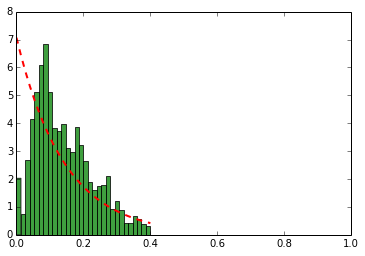

In [448]:
# Based on MLE estimate for fitting
fcn = expon
params = fcn.fit(1-metric_value)
n, bins, patches = plt.hist(1-metric_value, 30, normed=1, facecolor='green', alpha=0.75)
plt.xlim(0,1)
y = fcn.pdf( bins, *params)
RSS =sum((bins-y)**2)
R = np.corrcoef(bins,y)[0][1]
kolmogorov_smirnov(bins,y,metric)
l = plt.plot(bins, y, 'r--', linewidth=2)

In [455]:
np.histogram?

Jaccard [Self] : D = 1.0 ; p =0.0 ---> NOT from same distribution


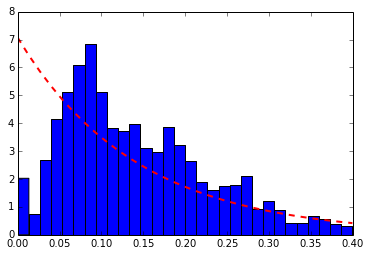

In [462]:
# Based on MLE estimate for fitting
fcn = expon
params = fcn.fit(1-metric_value)
n, bins, patches = plt.hist(1-metric_value, 30, normed=1)
y = fcn.pdf( bins, *params)
RSS =sum((bins-y)**2)
R = np.corrcoef(bins,y)[0][1]
kolmogorov_smirnov(bins,y,metric)
l = plt.plot(bins, y, 'r--', linewidth=2)

In [493]:
def kolmogorov_smirnov(data1,data2,name):
	'''
	See if data come from the same distribution
	'''
	result = stats.ks_2samp(data1,data2)
	if result[1]>0.05: print "{0} : D = {1} ; p ={2} ---> {3}".format(name,np.around(result[0],2),np.around(result[1],2),pcheck(result[1],"from same distribution"))

In [468]:
print dir(stats.distributions)[9:]

['alpha', 'anglit', 'arcsine', 'bernoulli', 'beta', 'betaprime', 'binom', 'boltzmann', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'division', 'dlaplace', 'dweibull', 'entropy', 'erlang', 'expon', 'exponpow', 'exponweib', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_l', 'frechet_r', 'gamma', 'gausshyper', 'genexpon', 'genextreme', 'gengamma', 'genhalflogistic', 'genlogistic', 'genpareto', 'geom', 'gilbrat', 'gompertz', 'gumbel_l', 'gumbel_r', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypergeom', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'levy', 'levy_l', 'levy_stable', 'loggamma', 'logistic', 'loglaplace', 'lognorm', 'logser', 'lomax', 'maxwell', 'mielke', 'nakagami', 'nbinom', 'ncf', 'nct', 'ncx2', 'norm', 'pareto', 'pearson3', 'planck', 'poisson', 'powerlaw', 'powerlognorm', 'powernorm', 'print_function', 'randint', 'rayleigh', 'rdist', 'recipinvgauss', 'reciprocal', 'rice', 'r

In [483]:
import scipy.stats

In [510]:
exclude= ['division', 'skellam', 'nbinom', 'logser', 'erlang','dlaplace', 'hypergeom', 'bernoulli', 'levy_stable', 'zipf', 'rv_discrete', 'rv_frozen', 'boltzmann', 'rv_continuous', 'entropy', 'randint', 'poisson', 'geom', 'binom', 'planck', 'print_function']

In [511]:
print filter(lambda x: x not in exclude,dir(stats.distributions)[9:])

['alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'expon', 'exponpow', 'exponweib', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_l', 'frechet_r', 'gamma', 'gausshyper', 'genexpon', 'genextreme', 'gengamma', 'genhalflogistic', 'genlogistic', 'genpareto', 'gilbrat', 'gompertz', 'gumbel_l', 'gumbel_r', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'levy', 'levy_l', 'loggamma', 'logistic', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncf', 'nct', 'ncx2', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rayleigh', 'rdist', 'recipinvgauss', 'reciprocal', 'rice', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_max', 'weibull_min', 'wrapcauchy']


Pearson's R tests strength of a linear association between two variables. It is probably not the best test for this application 

Precision [COCO]: mu = 0.869; std = 0.227
alpha : D = 0.29 ; p =0.12 ---> from same distribution
beta : D = 0.29 ; p =0.12 ---> from same distribution
burr : D = 0.19 ; p =0.56 ---> from same distribution
chi : D = 0.29 ; p =0.12 ---> from same distribution
chi2 : D = 0.23 ; p =0.36 ---> from same distribution
exponpow : D = 0.23 ; p =0.36 ---> from same distribution
exponweib : D = 0.29 ; p =0.12 ---> from same distribution
fatiguelife : D = 0.29 ; p =0.12 ---> from same distribution
fisk : D = 0.32 ; p =0.06 ---> from same distribution
frechet_r : D = 0.32 ; p =0.06 ---> from same distribution
gamma : D = 0.29 ; p =0.12 ---> from same distribution
gumbel_l : D = 0.32 ; p =0.06 ---> from same distribution
mielke : D = 0.16 ; p =0.78 ---> from same distribution
nakagami : D = 0.26 ; p =0.22 ---> from same distribution
ncx2 : D = 0.23 ; p =0.36 ---> from same distribution
pearson3 : D = 0.32 ; p =0.06 ---> from same distribution
recipinvgauss : D = 0.29 ; p =0.12 ---> from same distribu

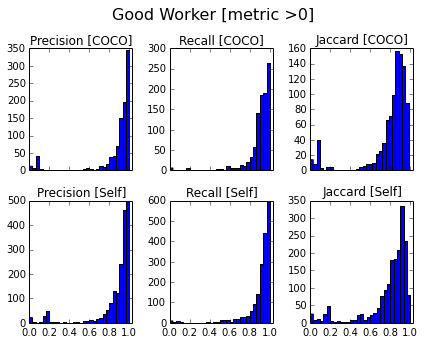

In [514]:
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
FILTER_CRITERION = 0
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW

fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
fig.suptitle("Good Worker [metric >{}]".format(FILTER_CRITERION),fontsize=16,y=1.05)
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

table_data = []
for i,metric in zip(range(len(metrics_lst)),metrics_lst):
    metric_value = np.array(bb_info[metric][bb_info[metric]>FILTER_CRITERION][bb_info[metric]<=1]) 
    table_data.append(basic_stat(metric_value,metric))
    ax = axs[i]
    ax.set_title(metric)
    ax.hist(metric_value,bins=30)
    ax.set_xlim(FILTER_CRITERION,1.03)
    #Testing against various distributions 
    
    for fcn_name in filter(lambda x: x not in exclude,dir(stats.distributions)[9:]):
        # Based on MLE estimate for fitting
        try:
            fcn = getattr(scipy.stats,fcn_name)
            params = fcn.fit(1-metric_value)
            histo,bins = np.histogram(1-metric_value, 30, normed=1)
            y = fcn.pdf(bins, *params)
            RSS =sum((bins-y)**2)
            R = np.corrcoef(bins,y)[0][1]
#             print "RSS:",RSS
#             print "R: ",R
            kolmogorov_smirnov(bins,y,fcn_name)
        except(AttributeError,NotImplementedError,TypeError):
            #function has no fitting
            print "Skipped", fcn_name
fig.tight_layout()
fig.savefig('good_worker_metric_histogram.pdf')

Precision [COCO]: mu = 0.931; std = 0.068
RSS: 55.2710138862
R:  0.49947367802
RSS: 142.637493015
R:  -0.787330268869
RSS: 1.49644493524e+27
R:  -0.306186217848
RSS: 612003792.603
R:  -0.306723289464
RSS: 825.458385251
R:  -0.774117283746
RSS: 192.945094788
R:  -0.967688941986
RSS: 3.26638068962e+47
R:  -0.306186217848
RSS: 386.983908706
R:  -0.747678425197
RSS: 1.15172452336e+16
R:  -0.306186337944
RSS: 3.32547168588e+12
R:  -0.306192706736
RSS: 161.269840078
R:  -0.89012497155
RSS: 354.577519284
R:  -0.849792821886
RSS: 345.776455401
R:  -0.843930502156
RSS: 462.278693209
R:  -0.744141818705
RSS: 6.72928464266e+16
R:  -0.306186267513
RSS: 470.495423131
R:  -0.743411442695
RSS: 776.427835357
R:  -0.782944278589
RSS: 545.108320958
R:  -0.77243864345
RSS: 1.6276949456e+25
R:  -0.30618621785
RSS: 582.659978958
R:  -0.794690048137
RSS: 465.635469696
R:  -0.924083601436
RSS: 8.14995628975e+21
R:  0.30618621791
RSS: 463.510456327
R:  -0.746670658459
RSS: 18597.7702492
R:  -0.405697120781
RS

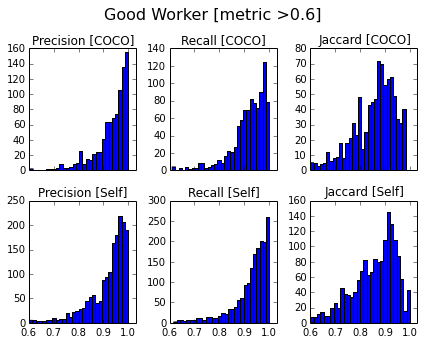

In [512]:
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
FILTER_CRITERION = 0.6
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW

fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
fig.suptitle("Good Worker [metric >{}]".format(FILTER_CRITERION),fontsize=16,y=1.05)
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

table_data = []
for i,metric in zip(range(len(metrics_lst)),metrics_lst):
    metric_value = np.array(bb_info[metric][bb_info[metric]>FILTER_CRITERION][bb_info[metric]<=1]) 
    table_data.append(basic_stat(metric_value,metric))
    ax = axs[i]
    ax.set_title(metric)
    ax.hist(metric_value,bins=30)
    ax.set_xlim(FILTER_CRITERION,1.03)
    #Testing against various distributions 
    
    for fcn_name in filter(lambda x: x not in exclude,dir(stats.distributions)[9:]):
        # Based on MLE estimate for fitting
        try:
            fcn = getattr(scipy.stats,fcn_name)
            params = fcn.fit(1-metric_value)
            histo,bins = np.histogram(1-metric_value, 30, normed=1)
            y = fcn.pdf(bins, *params)
            RSS =sum((bins-y)**2)
            R = np.corrcoef(bins,y)[0][1]
            print "RSS:",RSS
            print "R: ",R
            kolmogorov_smirnov(bins,y,fcn_name)
        except(AttributeError,NotImplementedError,TypeError):
            #function has no fitting
            print "Skipped", fcn_name
fig.tight_layout()
fig.savefig('good_worker_metric_histogram.pdf')

- Good Worker's Measures (filtered precision, recall >0.6)
- see if timing correlated with precision recall
- average time for a task for worker and good worker
- majority vote score statistics